# Olympic Effect with EuroSAT

## 2020년 09월 01일 안상호

In [1]:
from pathlib import Path

# Sangho Workspace|
root_dir = Path("/home/jovyan/")
base_dir = root_dir  / 'Land-Cls'

data_path = base_dir / "data" 

In [2]:
import sys
import os

# Google Colab Version
# sys.path.append(str(base_dir))


# Local Version
PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser("__file__"))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

In [72]:
from fastai.vision import *
from fastai.vision import image as im
from utils import preprocess, model #earth

# 1. Load  Classifier

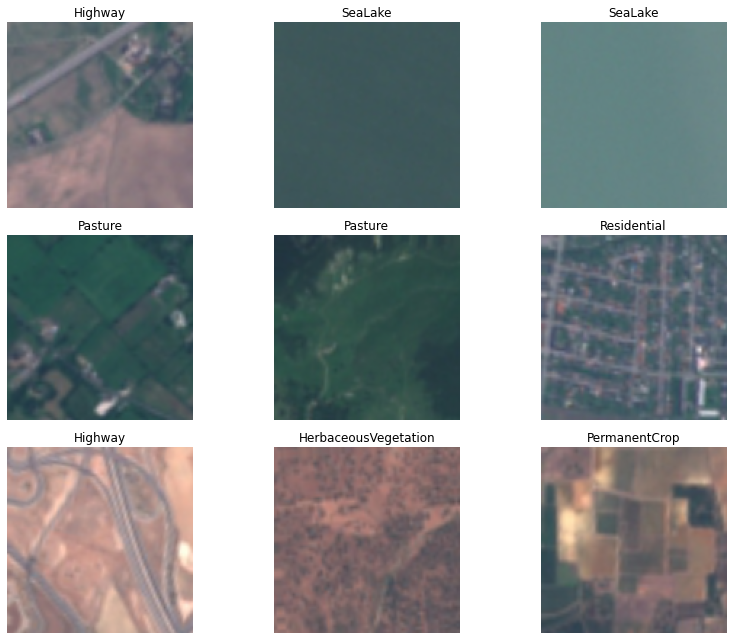

In [137]:


parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 128, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy],
    "pretrained" : False, 
    "load_dir": base_dir / "learn" / "euro-res101"
}

vis = model.FastVision(models.resnet101, parameters, task="classification")

# 2. Predict Land Cover

## 2.1. 이미지 크롭

In [138]:
import PIL
from torchvision import transforms

def crop_image_square(image, current_x, current_y, tile=(256, 256)):
    """
    PIL 이미지를 tile 만큼의 정방 형태의 크기로 crop 합니다.
    """
    return image.crop((current_x, current_y, current_x + tile[0], current_y + tile[1]))



def convert_fastai_image(image:PIL.JpegImagePlugin.JpegImageFile):
    """
    PIL 형태의 이미지를 fastai를 위한 Image로 바꿔준다. 
    Ref:: https://forums.fast.ai/t/how-to-convert-a-pil-image-to-a-fastai-image-object/68407/3
    """
    return im.Image(transforms.ToTensor()(image))



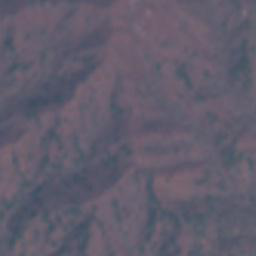

In [139]:
image = PIL.Image.open(data_path/ "olympic" / "y2016_PC_01_ Alpensia.jpg")



crop_image_square(image, 256 , 256)

In [177]:
def caculate_land_use(image_path, model, labels, tile=(64, 64)):
    image = PIL.Image.open(image_path)
    width, height = image.size
    tile_width, tile_height = tile
    
    result_dict = dict((label,0) for label in labels)
    currentx, currenty = (0, 0)
    
    
    while currenty < height:
        while currentx < width:
            #print(currentx,",",currenty)
            tile = crop_image_square(image, currentx, currenty, (tile_width, tile_height)) 

            result_dict[str(model.predict(convert_fastai_image(tile))[0])] +=1
            currentx += tile_width
        currenty += tile_height
        currentx = 0
    return result_dict
    
labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
          'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

result = caculate_land_use(data_path/ "olympic" / "y2018_PC_02_Station.jpg", vis.learn, labels, (256, 256))


In [178]:
def get_dict_percent(count_dict):
    values = count_dict.values()
    total = sum(values)
    return [value / total for value in values]

for k, v in zip(result.keys(), get_dict_percent(result)):
    print(f"{k}: {v}")

AnnualCrop: 0.025
Forest: 0.075
HerbaceousVegetation: 0.6833333333333333
Highway: 0.0
Industrial: 0.0
Pasture: 0.0
PermanentCrop: 0.008333333333333333
Residential: 0.15833333333333333
River: 0.008333333333333333
SeaLake: 0.041666666666666664


## 2.2. 장소별 적용

In [183]:
df_location = pd.DataFrame([["알펜시아", 37.658251, 128.669856, "PC_01_ Alpensia.jpg"],
                            ["진부역", 37.642935, 128.574451, "PC_02_Station.jpg"],
                            ["올림픽 게이트웨이", 37.668117, 128.705676, "PC_03_Gate.jpg"],
                            ["자연휴양", 37.705692, 128.720683, "PC_04_Nature.jpg"],
                            ["평창역", 37.562846,  128.429930, "PC_05_Station.jpg"]], columns=["name", "lat", "lon", "image_name"])

df_location.head()

,name,lat,lon,image_name
0,알펜시아,37.658251,128.669856,PC_01_ Alpensia.jpg
1,진부역,37.642935,128.574451,PC_02_Station.jpg
2,올림픽 게이트웨이,37.668117,128.705676,PC_03_Gate.jpg
3,자연휴양,37.705692,128.720683,PC_04_Nature.jpg
4,평창역,37.562846,128.429930,PC_05_Station.jpg


In [187]:
labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
          'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
cols = ["name", "year"] + labels

tile = (256, 256)

In [188]:
years = ["2016", "2017", "2018", "2019", "2020"]
result_list = []
for idx, row in df_location.iterrows():
    for year in years:
        meta_list = [row["name"], year]
        land_use = caculate_land_use(data_path/ "olympic" / "V2" /f"y{year}_{row.image_name}",
                                     vis.learn, labels, tile)
        result_list.append(meta_list + get_dict_percent(land_use))
        

        
df_result = pd.DataFrame(result_list, columns=cols)

In [189]:
df_result

,name,year,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
0,알펜시아,2016,0.000000,0.006494,0.506494,0.0,0.000000,0.000000,0.025974,0.292208,0.000000,0.168831
1,알펜시아,2017,0.000000,0.012987,0.662338,0.0,0.000000,0.000000,0.006494,0.142857,0.006494,0.168831
2,알펜시아,2018,0.000000,0.012987,0.467532,0.0,0.000000,0.000000,0.006494,0.350649,0.000000,0.162338
3,알펜시아,2019,0.000000,0.000000,0.512987,0.0,0.000000,0.000000,0.000000,0.324675,0.000000,0.162338
4,알펜시아,2020,0.000000,0.000000,0.370130,0.0,0.000000,0.000000,0.000000,0.454545,0.000000,0.175325
5,진부역,2016,0.000000,0.064935,0.474026,0.0,0.000000,0.000000,0.038961,0.259740,0.000000,0.162338
6,진부역,2017,0.000000,0.032468,0.642857,0.0,0.000000,0.000000,0.000000,0.168831,0.000000,0.155844
7,진부역,2018,0.000000,0.012987,0.538961,0.0,0.000000,0.000000,0.025974,0.266234,0.000000,0.155844
8,진부역,2019,0.000000,0.019481,0.571429,0.0,0.000000,0.000000,0.006494,0.246753,0.000000,0.155844
9,진부역,2020,0.000000,0.006494,0.435065,0.0,0.000000,0.000000,0.019481,0.383117,0.000000,0.155844


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
# df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })
 
# multiple line plot
plt.plot( 'year', 'y1', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.legend()


In [194]:
import plotly.express as px

# df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df_result, x="year", y="HerbaceousVegetation", color='name')
fig.show()

In [195]:
import plotly.express as px

# df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df_result, x="year", y="Residential", color='name')
fig.show()